# Import library

In [1]:
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score
from sklearn.utils.multiclass import unique_labels
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from fastai.callbacks import *
from fastai.basics import *
import torch.utils.data as utils
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import warnings
import numpy as np
import pandas as pd
import os
import glob
import csv
import os.path
import sys
import string
import multiprocessing
from multiprocessing import Pool
from tqdm import tqdm_notebook as tqdm
import random
from sklearn.externals import joblib
import pixiedust
random.seed(99)
pd.set_option('display.max_rows', 1000)
warnings.filterwarnings("ignore")
%matplotlib inline

Pixiedust database opened successfully


In [2]:
Acc_max_dict = {100: [8.5, 8.5, 8.5, 8.5, 8.5], 
         101: [3.0, 3.2, 3.4, 3.6, 3.8], 
         102: [1.5, 1.6, 1.7, 1.8, 1.9]}  
print(Acc_max_dict)

{100: [8.5, 8.5, 8.5, 8.5, 8.5], 101: [3.0, 3.2, 3.4, 3.6, 3.8], 102: [1.5, 1.6, 1.7, 1.8, 1.9]}


In [3]:
pave_type_dict = {0:'Dry', 1: 'Snow', 2:'Ice'}
pave_type_dict

{0: 'Dry', 1: 'Snow', 2: 'Ice'}

In [4]:
os.listdir()

['slippery_detection.ipynb',
 'ice.csv',
 'grey_best.hdf5',
 'sample_data_recurrence_plot_grey.ipynb',
 'ParseVissimOutput_Fzp_Rsr.py',
 'HV_primary_columns.ods',
 'Center ID.csv',
 'Curve_fig',
 'Literature review.docx',
 'Parameter_tuning_1.csv',
 'S1_data_analysis.ipynb',
 'cm.png',
 'sample_data_recurrence_plot_rgb.ipynb',
 'create_weather_data.ipynb',
 'sample_data_img_cnn.ipynb',
 '__pycache__',
 'sample_data_regression.ipynb',
 'Draw_figure.ipynb',
 'preciptation data',
 'weather_dict.pkl',
 'ODE_Output_Schema_Reference.docx',
 'dry.csv',
 'Data_vissim.ipynb',
 'S1_LSTM.ipynb',
 'snow.csv',
 'ArcGIS',
 'vissim',
 'sample_data_parameter_Opt_1.ipynb',
 'Data_cleaning.ipynb',
 'models',
 'Parameter_tuning.csv',
 'AA_S1.csv',
 'Safety_Pilot_Model_Deployment_Sample_Data_Handbook.docx',
 'Precipitation.csv',
 'Recurrence_fig',
 'sample_data_curve_cnn.ipynb',
 'load_Wyoming _data.ipynb',
 'best.hdf5',
 '.ipynb_checkpoints',
 'DriveAlong.mpg',
 'sample_data_lstm.ipynb']

# Data Preprocessing

## Segment dataset

In [3]:
path = '/media/jiajie/Data/Slippery/S1/AA_S1.csv'
df = pd.read_csv(path)

In [5]:
df.head()

,SIMSEC,NO,VEHTYPE,LANE-LINK-NO,LANE-INDEX,POS,ACCELERATION,SPEED,WHEELSPEED,DESSPEED,QTIME,X,Y,WACCELERATION,INTER
0,6.7,1,100,1,1,99.818,0.28,67.23,67.15,66.95,0.0,-78.621,-133.632,0.28,2
1,6.8,1,100,1,1,101.684,-0.10,67.19,66.96,66.95,0.0,-77.197,-132.419,-0.10,2
2,6.9,1,100,1,1,103.549,-0.41,67.05,67.37,66.95,0.0,-75.775,-131.207,-0.41,2
3,7.0,1,100,1,1,105.408,-0.66,66.81,67.18,66.95,0.0,-74.358,-129.999,-0.66,2
4,7.1,1,100,1,1,107.259,-0.87,66.50,66.64,66.95,0.0,-72.946,-128.796,-0.87,2


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21244413 entries, 0 to 21244412
Data columns (total 15 columns):
SIMSEC           float64
NO               int64
VEHTYPE          int64
LANE-LINK-NO     int64
LANE-INDEX       int64
POS              float64
ACCELERATION     float64
SPEED            float64
WHEELSPEED       float64
DESSPEED         float64
QTIME            float64
X                float64
Y                float64
WACCELERATION    float64
INTER            int64
dtypes: float64(10), int64(5)
memory usage: 2.4 GB


In [7]:
len(set(df.NO))

26047

In [10]:
def get_max_acc(veh_no, pave_type):
    if veh_no in range(1, 5261):
        return Acc_max_dict[pave_type][0]
    elif veh_no in range(5261, 10431):
        return Acc_max_dict[pave_type][1]
    elif veh_no in range(10431, 15733):
        return Acc_max_dict[pave_type][2]
    elif veh_no in range(15733, 20907):
        return Acc_max_dict[pave_type][3]
    else:
        return Acc_max_dict[pave_type][4]  

In [246]:
temp = df[['X', 'Y', 'ACCELERATION', 'WACCELERATION', 'SPEED', 'WHEELSPEED','SIMSEC']][20:31].values

In [251]:
def create_training_data(df):  
    window = 10
    samples = []
    targets = []
    locations = [] #[Lons, Lats, veh_no, inter_no, max_acc, Time]
    for pave_type, vehs_type in df.groupby('VEHTYPE'):
        for inter, vehs_inter in vehs_type.groupby('INTER'):
            for i in set(vehs_inter.NO):            
                veh = vehs_inter[['X', 'Y', 'ACCELERATION', 'WACCELERATION', 'SPEED', 'WHEELSPEED','SIMSEC']][df.NO == i].values
                rows = np.asarray(range(0, len(veh)-window+1, 5))
                for row in rows:
                    temp = veh[row:row+window,:]
                    if np.round(temp[9,6] - temp[0,6], 1) != 0.9  or len(temp[temp[:,3] == 0]) >= 5:
                        continue
                    max_acc = get_max_acc(i, pave_type)
                    if pave_type in [101, 102] and len(temp[abs(temp[:,3]) > max_acc]) < 5:
                        continue
                    locations.append([np.mean(temp[:,0]), np.mean(temp[:,1]), i, inter, max_acc, temp[9,6]])
                    targets.append(pave_type-100)
                    samples.append(temp[:,2:6])
    return np.asarray(samples), np.asarray(targets), np.asarray(locations)

In [252]:
def parallelize_dataframe(df, func):
    num_partitions = num_cores = multiprocessing.cpu_count()
    data_split = np.array_split(df, num_partitions)
    pool = Pool(num_cores)
    df = pool.map(func, data_split)
    pool.close()
    pool.join()
    return df

In [253]:
def parallel_create_training_data(df):
    a = parallelize_dataframe(df[df.SIMSEC <= 1800], create_training_data) 
    b = parallelize_dataframe(df[(df.SIMSEC >= 1811) & (df.SIMSEC <= 2700)], create_training_data) 
    c = parallelize_dataframe(df[(df.SIMSEC >= 2710)], create_training_data)
    for i, Vehs in enumerate([*a, *b, *c]):
        if i == 0:
            samples = Vehs[0]
            targets = Vehs[1]
            locations = Vehs[2]
        else:
            samples = np.concatenate([samples, Vehs[0]])
            targets = np.concatenate([targets, Vehs[1]])
            locations = np.concatenate([locations, Vehs[2]])
    return samples, targets, locations

In [254]:
samples, targets, locations = parallel_create_training_data(df)

In [255]:
samples.shape, targets.shape , locations.shape

((732910, 10, 4), (732910,), (732910, 6))

In [266]:
# np.save('samples', samples)
# np.save('targets', targets)
# np.save('locations', locations)
# samples = np.load('samples.npy')
# targets = np.load('targets.npy')
# locations = np.load('locations.npy')

In [260]:
samples[100000], targets[100000], locations[100000]

(array([[-0.27, -0.27, 66.27, 66.78],
        [-0.27, -0.27, 66.18, 66.67],
        [-0.27, -0.27, 66.08, 65.59],
        [-0.27, -0.27, 65.98, 66.24],
        [-0.27, -0.27, 65.88, 66.03],
        [-0.27, -0.27, 65.78, 65.45],
        [-0.27, -0.27, 65.68, 65.48],
        [-0.27, -0.27, 65.59, 65.89],
        [-0.27, -0.27, 65.49, 65.6 ],
        [-0.27, -0.27, 65.39, 66.25]]),
 0,
 array([-3.6514e+01, -8.9566e+01,  5.2700e+03,  2.0000e+00,  8.5000e+00,  1.7600e+01]))

## Imbalance data sampling

In [270]:
unique, counts = np.unique(targets, return_counts=True)
np.array([unique, counts])

array([[     0,      1,      2],
       [399681,  51032, 282197]])

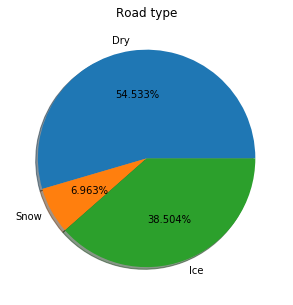

In [271]:
plt.figure(figsize=(5,5))
plt.pie(counts,labels = ['Dry','Snow','Ice'],autopct='%1.3f%%',shadow=True)
plt.title('Road type');

In [272]:
random.seed(99)
dry_index = np.where(targets == 0)[0]
dry_index = random.sample(list(dry_index), k= counts[0] - counts[2])

In [273]:
targets = np.delete(targets, dry_index, axis = 0)
samples = np.delete(samples, dry_index, axis = 0)
locations = np.delete(locations, dry_index, axis = 0)

In [274]:
samples.shape

(615426, 10, 4)

In [275]:
unique, counts = np.unique(targets, return_counts=True)
np.array([unique, counts])

array([[     0,      1,      2],
       [282197,  51032, 282197]])

In [276]:
rus = RandomOverSampler(random_state=99)
_ = rus.fit_sample(targets.reshape(-1, 1),targets.reshape(-1, 1))
indices = rus.sample_indices_
samples = samples[indices]
targets = targets[indices]
locations  =locations[indices]

[[     0      1      2]
 [282197 282197 282197]]


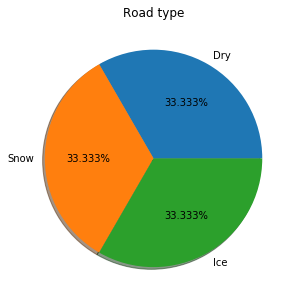

In [277]:
unique, counts = np.unique(targets, return_counts=True)
print(np.array([unique, counts]))
plt.figure(figsize=(5,5))
plt.pie(counts,labels = ['Dry','Snow','Ice'],autopct='%1.3f%%',shadow=True)
plt.title('Road type');

## Data visulization

[[1.0000e+00 2.0000e+00 3.0000e+00 4.0000e+00 5.0000e+00 6.0000e+00]
 [2.4116e+05 1.6000e+05 1.3915e+05 6.1676e+04 1.9614e+05 4.8462e+04]]


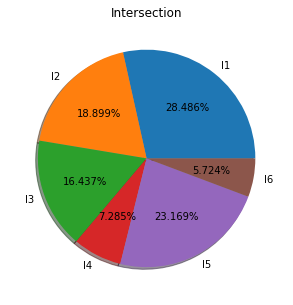

In [278]:
unique, counts = np.unique(locations[:,3], return_counts=True)
print(np.array([unique, counts]))
plt.figure(figsize=(5,5))
plt.pie(counts,labels = ['I' + str(i) for i in range(1,7)],autopct='%1.3f%%',shadow=True)
plt.title('Intersection');

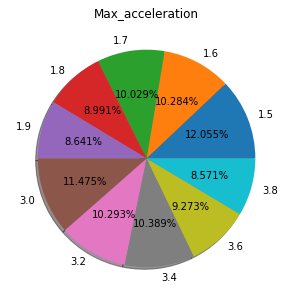

In [279]:
unique, counts = np.unique(locations[:,4], return_counts=True)
np.array([unique, counts])
plt.figure(figsize=(5,5))
plt.pie(counts[:-1],labels = unique[:-1],autopct='%1.3f%%',shadow=True)
plt.title('Max_acceleration');

In [112]:
def hist_of_speed_acc__diff(pave_type, samples, targets):
    # pave_type = 0, 1, 2
    # samples = ['ACCELERATION', 'WACCELERATION', 'SPEED', 'WHEELSPEED']
    vehs_data = samples[targets==pave_type]
    std_list = []
    mean_list = []
    max_list = []
    for veh in vehs_data:
        diff_s = veh[2] - veh[3]
        diff_a = veh[0] - veh[1]
        std_list.append([np.std(diff_s), np.std(diff_a)])
        mean_list.append([np.mean(diff_s), np.mean(diff_a)])
        max_list.append([diff_s[np.argmax(abs(diff_s))], diff_s[np.argmax(abs(diff_a))]])
    fig = plt.figure(figsize=(15, 8))
    fig.subplots_adjust(wspace=0.3, hspace=0.2)
    fig.suptitle(f'Vehicles driving on {pave_type_dict[pave_type]}')
    
    plt.subplot(2,3,1)
    plt.hist(mean_list[0])
    plt.xlabel('mean_diff_speed')
    plt.ylabel('count')
    plt.subplot(2,3,2)
    plt.hist(std_list[0])
    plt.xlabel('std_diff_speed')
    plt.ylabel('count')
    plt.subplot(2,3,3)
    plt.hist(max_list[0])
    plt.xlabel('max_diff_speed')
    plt.ylabel('count')
    
    plt.subplot(2,3,4)
    plt.hist(mean_list[1])
    plt.xlabel('mean_diff_acc')
    plt.ylabel('count')
    plt.subplot(2,3,5)
    plt.hist(std_list[1])
    plt.xlabel('std_diff_acc')
    plt.ylabel('count')
    plt.subplot(2,3,6)
    plt.hist(max_list[1])
    plt.xlabel('max_diff_acc')
    plt.ylabel('count')

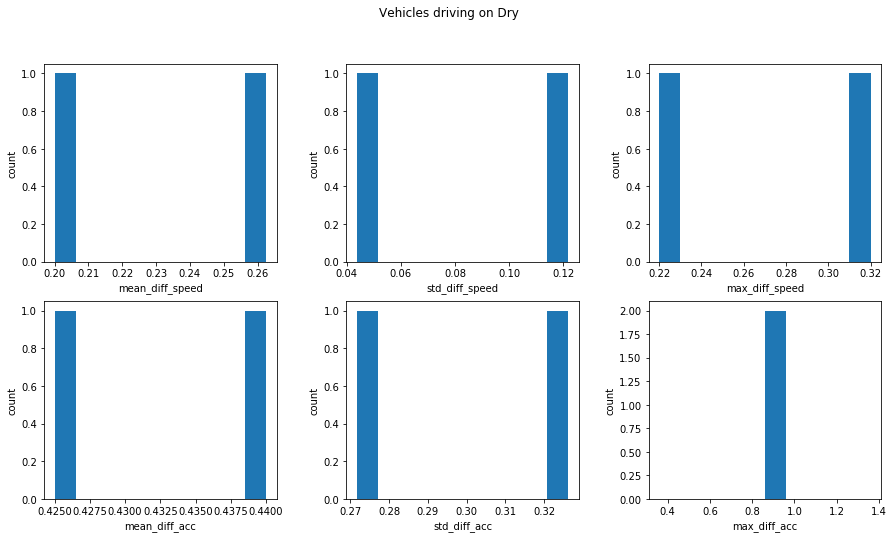

In [113]:
hist_of_speed_acc__diff(0, samples, targets)

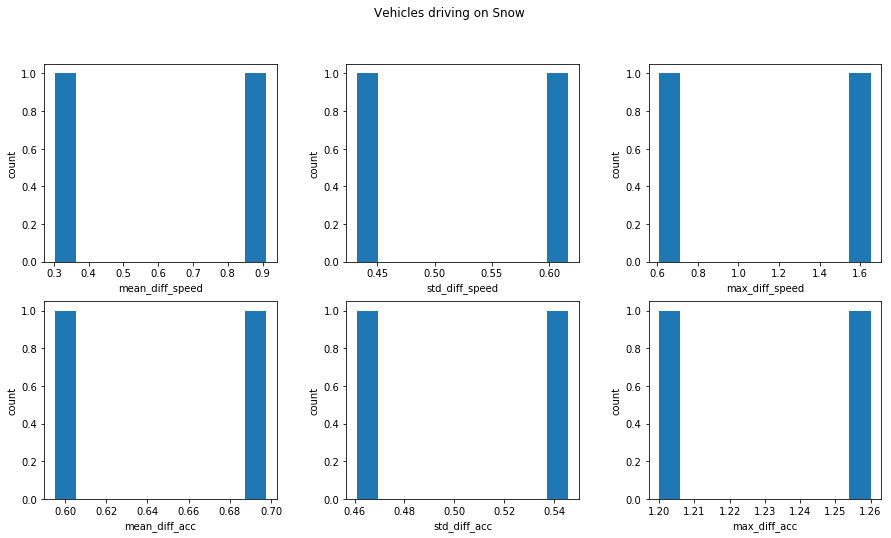

In [109]:
hist_of_speed_acc__diff(1, samples, targets)

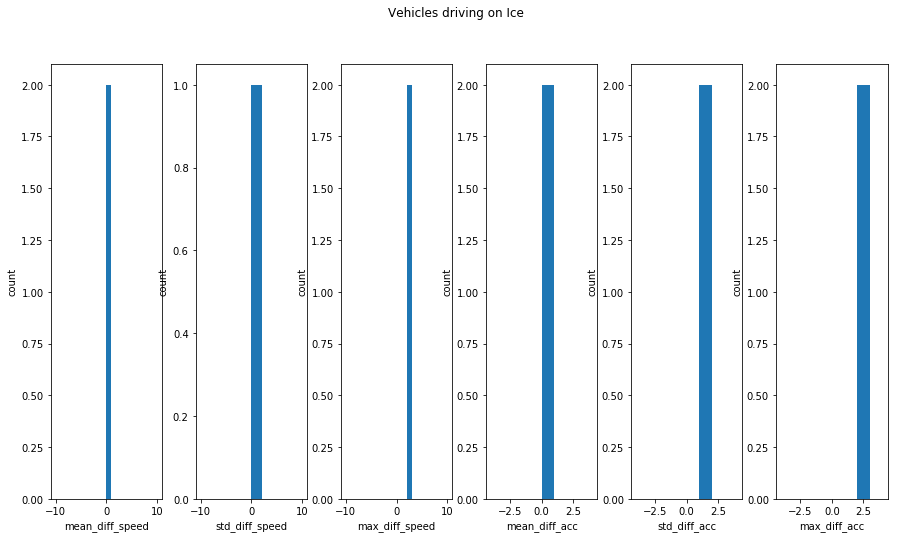

In [102]:
hist_of_speed_acc__diff(2, samples, targets)

In [119]:
def hist_of_vehicles_data(samples, targets):
    # pave_type = 0, 1, 2
    # samples = ['ACCELERATION', 'WACCELERATION', 'SPEED', 'WHEELSPEED']
    for pave_type in [0, 1, 2]:
        
        vehs_data = samples[targets==pave_type]
        fig = plt.figure(figsize=(15, 8))
        fig.subplots_adjust(wspace=0.3, hspace=0.2)
        fig.suptitle(f'Vehicles driving on {pave_type_dict[pave_type]}')

        plt.subplot(1,4,1)
        plt.hist(vehs_data.reshape(-1,4)[:,0])
        plt.xlabel('ACCELERATION')
        plt.ylabel('count')
        plt.subplot(1,4,2)
        plt.hist(vehs_data.reshape(-1,4)[:,1])
        plt.xlabel('WACCELERATION')
        plt.ylabel('count')
        plt.subplot(1,4,3)
        plt.hist(vehs_data.reshape(-1,4)[:,2])
        plt.xlabel('SPEED')
        plt.ylabel('count')
        plt.subplot(1,4,4)
        plt.hist(vehs_data.reshape(-1,4)[:,3])
        plt.xlabel('WHEELSPEED')
        plt.ylabel('count')    

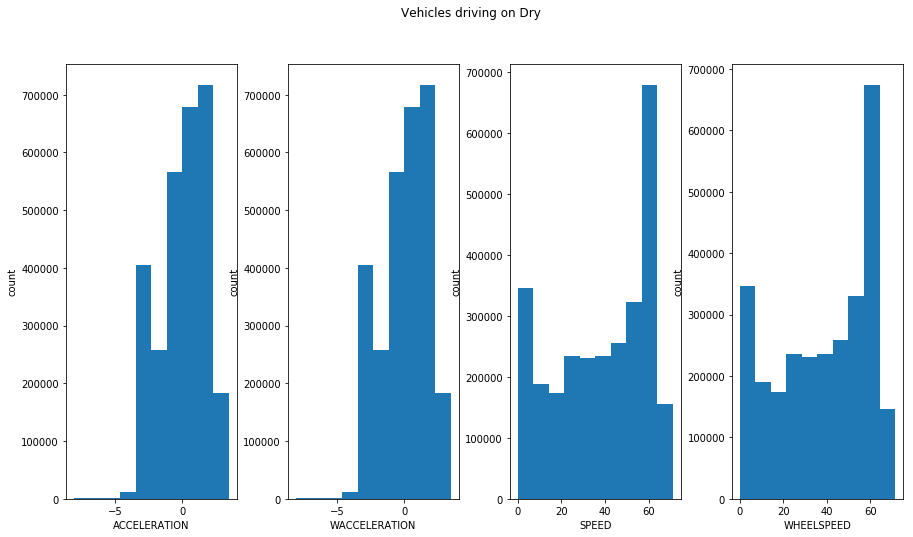

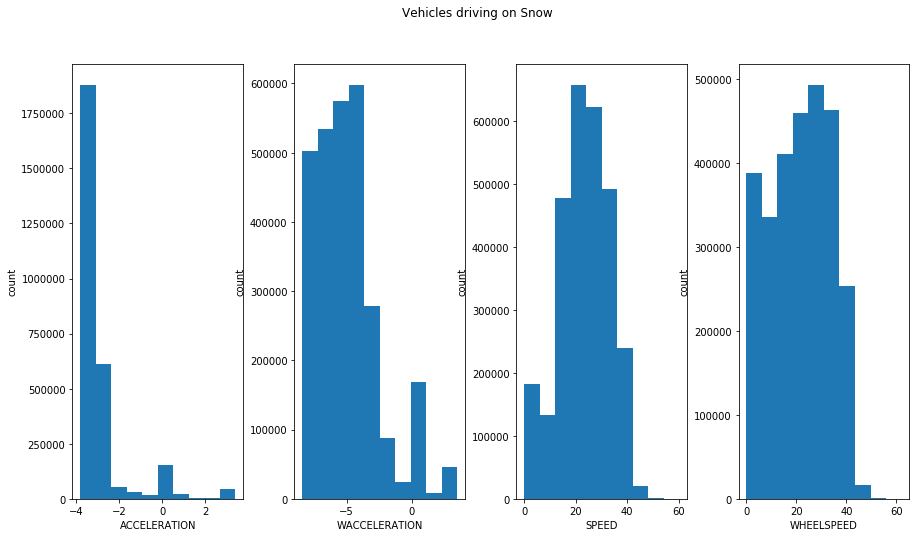

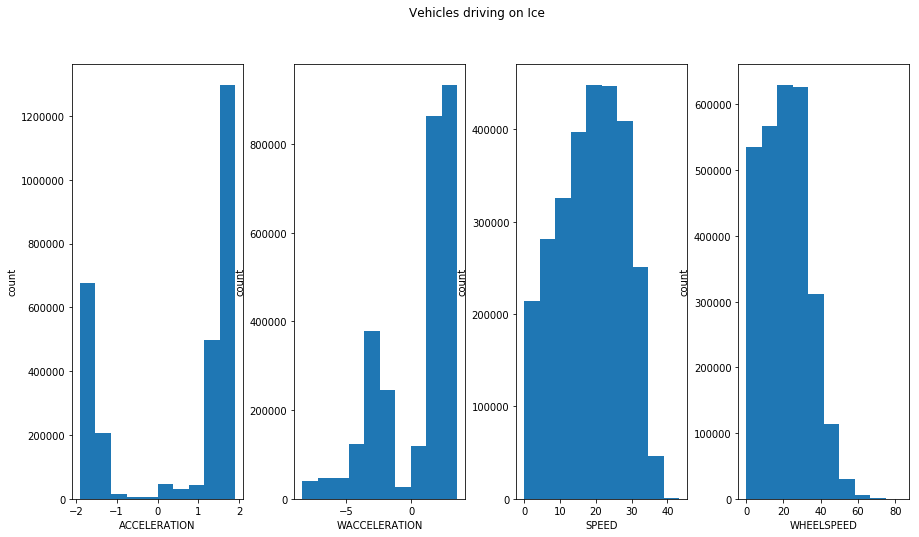

In [280]:
hist_of_vehicles_data(samples, targets)

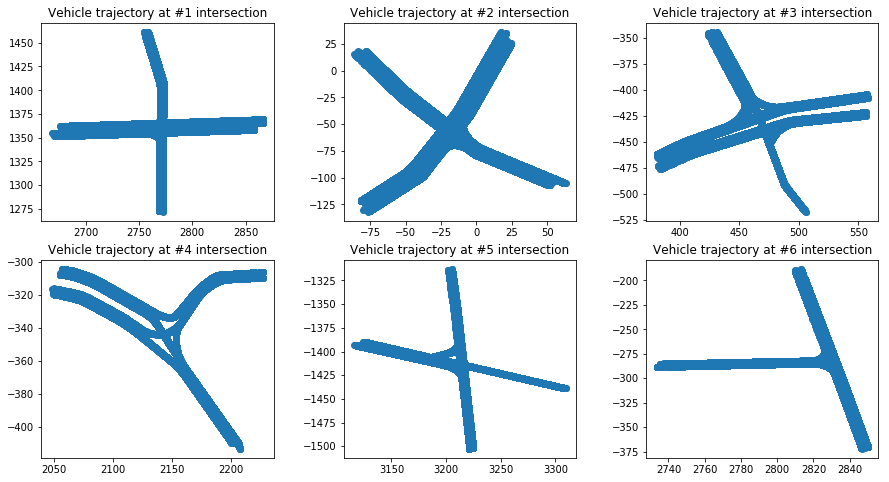

In [256]:
fig = plt.figure(figsize=(15, 8))
fig.subplots_adjust(wspace=0.3, hspace=0.2)

for i in range(1,7):
    plt.subplot(2,3,i)
    plt.scatter(locations[locations[:,3]==i,0], locations[locations[:,3]==i,1])
    plt.title(f'Vehicle trajectory at #{i} intersection')

In [5]:
def draw_data_segment_features(samples, targets, locations, pave_type):
    #samples = ['ACCELERATION', 'WACCELERATION', 'SPEED', 'WHEELSPEED']
    #locations = [Lons, Lats, veh_no, inter_no, max_acc, Time]
    Vehs = samples[targets == pave_type]
    indexs_list = random.choices(list(range(len(Vehs))), k=6)
    fig = plt.figure(figsize=(20, 12))
    fig.subplots_adjust(wspace=0.3, hspace=.2)
    
    for i, index in enumerate(indexs_list):
        Veh = Vehs[index]
        Vehs_NO = int(locations[index, 2])
        Inter_NO = int(locations[index, 3])
        End_time = locations[index, 5]
        
        #Time_small = [End_time - i*0.1 for i in range(10)[::-1]] 
        Time_small = [1,2,3,4,5,6,7,8,9,10] 
        Accel_small = Veh[:,0]
        WAccel_small = Veh[:,1]
        Speed_small = Veh[:,2]
        Wspeed_small = Veh[:,3]
        
        ax1 = plt.subplot(2, 3, i + 1)
        ax1.plot(Time_small, Speed_small, 'r', label='Driving speed')
        ax1.plot(Time_small, Wspeed_small, 'b', label='Wheel speed')
        ax1.plot(np.nan, 'y', label = 'WAcceleration')
        ax1.plot(np.nan, 'g', label='Acceleration')

        ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax1.yaxis.set_major_locator(ticker.MultipleLocator(5))
        ax1.set_ylim(0, 70)

        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('Speed (km/h)')

        ax2 = ax1.twinx()
        ax2.plot(Time_small, WAccel_small, 'y', label='Acceleration')
        ax2.plot(Time_small, Accel_small, 'g', label='Acceleration')
        ax2.set_ylabel('Acceleration (m/s2)')
        ax2.set_ylim(-8, 4)
        ax2.yaxis.set_major_locator(ticker.MultipleLocator(1))

        ax1.legend(loc="lower right", frameon=False)
        ax1.set_title(
            f"Vehicle #{Vehs_NO} Driving On {pave_type_dict[pave_type]} Road at Intersection #{Inter_NO}")
        ax1.grid()

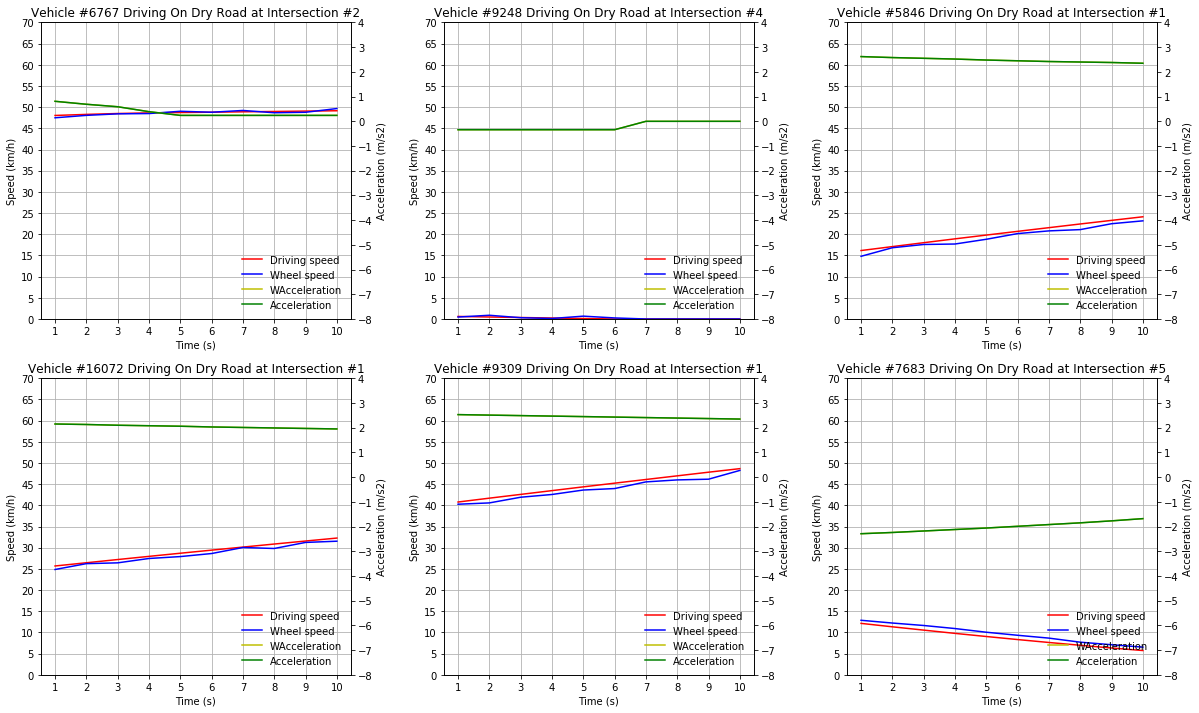

In [6]:
draw_data_segment_features(train_X, train_Y, train_loc, 0)

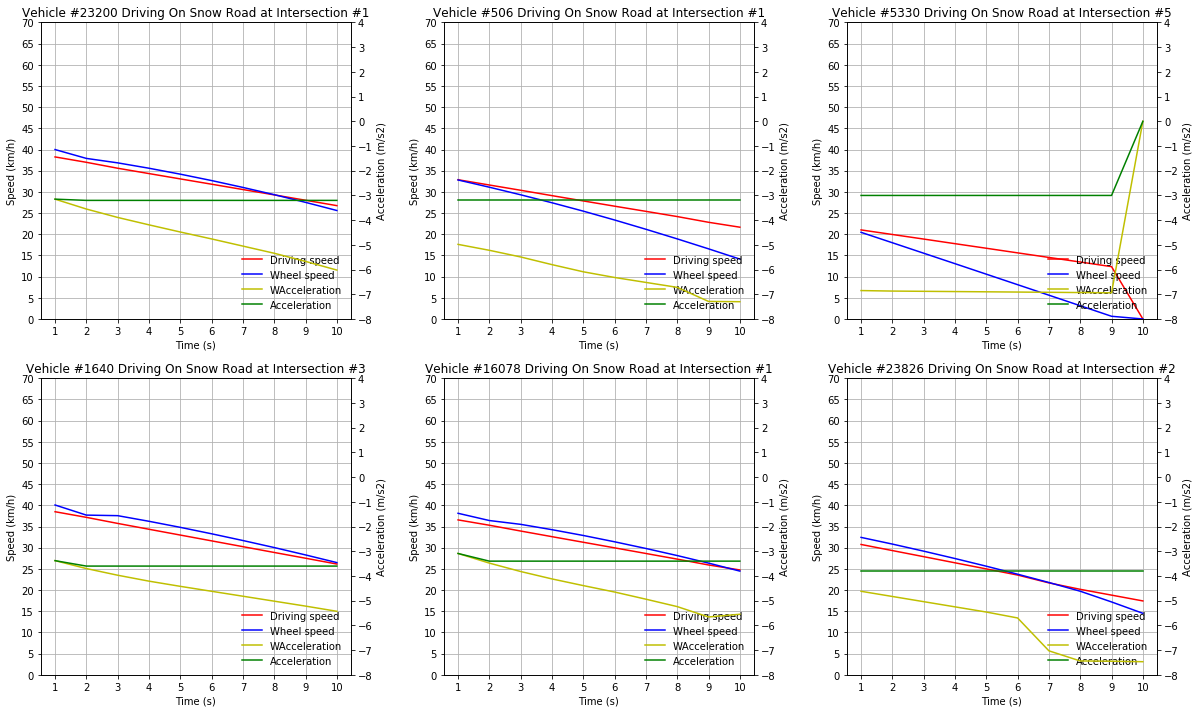

In [7]:
draw_data_segment_features(train_X, train_Y, train_loc, 1)

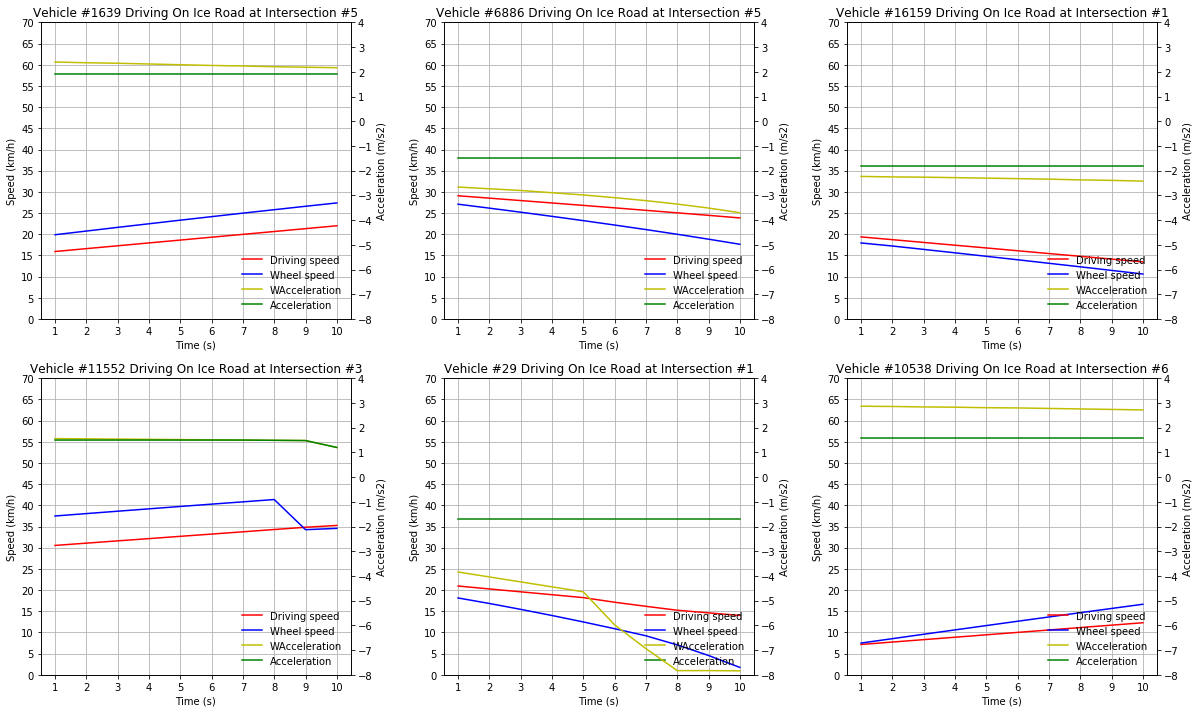

In [8]:
draw_data_segment_features(train_X, train_Y, train_loc, 2)

## Data standization

In [281]:
train_X = samples.copy()
train_X_scaled = StandardScaler().fit_transform(train_X.reshape(-1,4))
train_X_scaled = train_X_scaled.reshape(-1,10,4)
train_Y = targets.copy()
train_loc = locations
sorted(Counter(train_Y).items())

[(0, 282197), (1, 282197), (2, 282197)]

In [ ]:
scaler_filename = "scaler"
joblib.dump(scaler, scaler_filename) 

In [15]:
print(scaler.mean_)
print(scaler.var_)

[-0.793251 -1.481687 26.826228 27.011748]
[  4.650819  11.306335 282.544464 315.210608]


In [282]:
train_X, train_X_scaled, train_Y, train_loc = shuffle(train_X, train_X_scaled, train_Y, train_loc, random_state=99)

In [4]:
# np.save('train_X', train_X)
# np.save('train_X_scaled', train_X_scaled)
# np.save('train_Y', train_Y)
# np.save('train_loc', train_loc)
path = '/media/jiajie/Data/Slippery/S1/'
train_X_scaled = np.load(path+'train_X_scaled.npy')
train_X = np.load(path+'train_X.npy')
train_Y = np.load(path+'train_Y.npy')
train_loc = np.load(path+'train_loc.npy')

# Training with fastai

In [5]:
class Time_Series_Data(Dataset):
    def __init__(self, train_x, train_y):
        self.X = train_x
        self.y = train_y
    def __getitem__(self, item):
        x_t = self.X[item]
        y_t = self.y[item]
        return x_t, y_t
    def __len__(self):
        return len(self.X)

In [6]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, output_size=3):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
#        hidden = (            # hidden = ([layers, batch, hidden], [layers, batch, hidden])
#            torch.zeros(self.num_layers, x.size(0), self.hidden_size),
#            torch.zeros(self.num_layers, x.size(0), self.hidden_size)
#        )
        
#        out, _ = self.lstm(x, hidden) # out = [batch, seq, hidden]
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :]) # out[:, -1, :] = [batch, hidden]   last seq
        return out

In [32]:
indices = list(range(len(train_Y)))
train_indices, valid_indices, _, _ = train_test_split(indices, train_Y, test_size=0.2, random_state=99, stratify=train_Y)

In [10]:
train_X_scaled = train_X_scaled.astype('float32')
train_Y = train_Y.astype('int64')

X_train, X_valid, y_train, y_valid = train_test_split(train_X_scaled, train_Y, test_size=0.2, random_state=99, stratify=train_Y)
train_loc, valid_loc, _, _ = train_test_split(train_loc, train_Y, test_size=0.2, random_state=99, stratify=train_Y)

trn_ds = Time_Series_Data(X_train, y_train)
val_ds = Time_Series_Data(X_valid, y_valid)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

## Bayes optimization

In [7]:
from GPyOpt.methods import BayesianOptimization
import GPyOpt

In [8]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(99)

In [62]:
opt_BO = [{'name': 'num_lay', 'type': 'discrete', 'domain': [1,2,3,4,5,6]},
          {'name': 'num_c', 'type': 'discrete', 'domain': [4,8,16,32,64,128,256]},
          {'name': 'dropout', 'type': 'discrete', 'domain': [0,0.1,0.2,0.3,0.4,0.5]},
          {'name': 'bs', 'type': 'discrete', 'domain': [64,128,256,512,1024,2048]}]

In [63]:
def lstm_fit(hidden_layer,hidden_size,dropout,batch_size):
    
    input_size = X_train.shape[2]
    net = LSTM(input_size,hidden_size,hidden_layer,dropout)  
    databunch = DataBunch.create(trn_ds,val_ds, device=device, bs=batch_size)    
    learn = Learner(databunch,net,loss_func = nn.CrossEntropyLoss(), metrics = [accuracy])
    learn.fit_one_cycle(20, 1e-2)

    val_pred, val_real= learn.get_preds(ds_type=DatasetType.Valid)
    val_pred = np.argmax(val_pred.numpy(), axis=1)
    val_acc = accuracy_score(val_real.numpy(), val_pred)
    return val_acc

In [51]:
def call_counter(func):
    """Call counter decorator"""

    def helper(*args, **kwargs):
        helper.calls += 1
        return func(*args, **kwargs)

    helper.calls = 0
    helper.__name__ = func.__name__
    return helper

In [52]:
def print_params(p, bds):
    s = ""
    for p, b in zip(p, bds):
        tmp = f"| {b['name']}: {p:.2f} "
        s += tmp
    print(s + '|' + '\n')

In [53]:
@call_counter
def f_opt_lstm(parameters):
    parameters = parameters[0]  # np.ndarray passed in is nested
    print(f'---------Starting Bay opt call {f_opt_lstm.calls} with parameters: ---------')
    print_params(parameters, opt_BO)
    score = lstm_fit(int(parameters[0]),int(parameters[1]),parameters[2],int(parameters[3]))
    return np.array(score)

In [64]:
optimizer = BayesianOptimization(f=f_opt_lstm,  # objective function
                 domain=opt_BO,
                 model_type='GP',
                 acquisition_type='EI',
                 normalize_Y=False,
                 acquisition_jitter=0.05,  # positive value to make acquisition more explorative
                 exact_feval=False,  # whether the outputs are exact
                 maximize=True,
                 verbosity=1,
                )
optimizer.run_optimization(max_iter=35)  # 5 initial exploratory points + max_iter

In [65]:
optimizer.X.shape

(40, 4)

In [67]:
optimizer.save_report(report_file='Bayes_results')
optimizer.save_evaluations('ev_file')
print_params(optimizer.x_opt, opt_BO)

| num_lay: 4.00 | num_c: 256.00 | dropout: 0.10 | bs: 256.00 |



In [69]:
optimizer.Y_best

array([-0.999976, -0.999976, -0.999988, -0.999988, -0.999988, -0.999988, -0.999988, -0.999988, -0.999994, -0.999994,
       -0.999994, -0.999994, -0.999994, -0.999994, -0.999994, -0.999994, -0.999994, -0.999994, -0.999994, -0.999994,
       -0.999994, -0.999994, -0.999994, -0.999994, -0.999994, -0.999994, -0.999994, -0.999994, -0.999994, -0.999994,
       -0.999994, -0.999994, -0.999994, -0.999994, -0.999994, -0.999994, -0.999994, -1.      , -1.      , -1.      ])

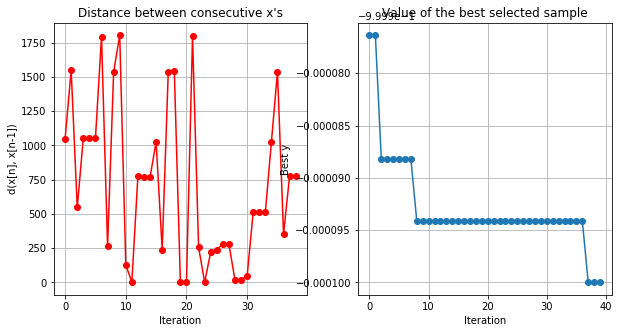

In [68]:
optimizer.plot_convergence()

## Create best model

In [79]:
num_lay,num_c,dropout,bs = 4, 256, 0.10, 256
input_size = train_X_scaled.shape[2]
net = LSTM(input_size, num_c, num_lay, dropout)
criterion =  nn.CrossEntropyLoss()
databunch = DataBunch.create(trn_ds,val_ds, device=device, bs=bs)    
#net.double()

In [80]:
learn = Learner(databunch,net,callback_fns=[ShowGraph],loss_func = criterion, metrics = [accuracy])
#partial(EarlyStoppingCallback, monitor='accuracy', min_delta=0.0001, patience=50)]               
#learn.lr_find()
#learn.recorder.plot(suggestion=True)
#learn.recorder.min_grad_lr

epoch,train_loss,valid_loss,accuracy,time
0,0.005449,0.005623,0.997484,00:37
1,0.012483,0.014066,0.995068,00:37
2,0.021411,0.038410,0.987438,00:38
3,0.013881,0.003127,0.998825,00:37
4,0.013435,0.007015,0.997945,00:35
5,0.007814,0.003882,0.998754,00:35
6,0.005802,0.005417,0.998996,00:35
7,0.006831,0.002618,0.999215,00:35
8,0.007116,0.002666,0.999368,00:35
9,0.024329,0.015148,0.994755,00:35


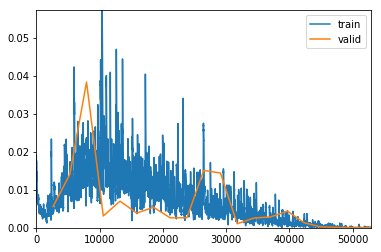

Better model found at epoch 0 with val_loss value: 0.005622914992272854.
Better model found at epoch 3 with val_loss value: 0.003126523457467556.
Better model found at epoch 7 with val_loss value: 0.0026183186564594507.
Better model found at epoch 11 with val_loss value: 0.001061921939253807.
Better model found at epoch 16 with val_loss value: 0.0002411810855846852.
Better model found at epoch 17 with val_loss value: 9.305382263846695e-05.
Better model found at epoch 18 with val_loss value: 4.199698014417663e-05.


In [82]:
lr=1e-2
learn.fit_one_cycle(20, lr,callbacks=SaveModelCallback(learn, name='S1_LSTM_Bayes'))

In [48]:
learn.summary

<bound method model_summary of Learner(data=DataBunch;

Train: <__main__.Time_Series_Data object at 0x7fe59e1d1fd0>;

Valid: <__main__.Time_Series_Data object at 0x7fe60a4c7828>;

Test: None, model=LSTM(
  (lstm): LSTM(4, 32, num_layers=4, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=32, out_features=3, bias=True)
), opt_func=functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99)), loss_func=CrossEntropyLoss(), metrics=[<function accuracy at 0x7fe5b396f0d0>], true_wd=True, bn_wd=True, wd=0.01, train_bn=True, path=PosixPath('.'), model_dir='models', callback_fns=[functools.partial(<class 'fastai.basic_train.Recorder'>, add_time=True, silent=False), <class 'fastai.train.ShowGraph'>, functools.partial(<class 'fastai.callbacks.tracker.EarlyStoppingCallback'>, monitor='accuracy', min_delta=0.0001, patience=50)], callbacks=[], layer_groups=[Sequential(
  (0): LSTM(4, 32, num_layers=4, batch_first=True, dropout=0.5)
  (1): Linear(in_features=32, out_features=3, bias

In [21]:
learn.save('S1_LSTM')

In [22]:
learn = learn.load('S1_LSTM')

# Evaluation

## Accuracy and Comfusion matrix

In [46]:
#interp = ClassificationInterpretation.from_learner(learn)
#interp.confusion_matrix()

In [83]:
learn.data.valid_ds[1]

(array([[0.446658, 0.491209, 2.075891, 1.947613],
        [0.446658, 0.491209, 2.080055, 1.94705 ],
        [0.446658, 0.491209, 2.083625, 1.98704 ],
        [0.446658, 0.491209, 2.087194, 1.949303],
        [0.446658, 0.491209, 2.091359, 2.012949],
        [0.446658, 0.491209, 2.094928, 1.986477],
        [0.446658, 0.491209, 2.098498, 1.958878],
        [0.446658, 0.491209, 2.102067, 1.996052],
        [0.446658, 0.491209, 2.106232, 1.989293],
        [0.446658, 0.491209, 2.109801, 2.009007]], dtype=float32), 0)

In [84]:
trn_pred, trn_real= learn.get_preds(ds_type=DatasetType.Train)
trn_pred =trn_pred.numpy()
trn_pred = np.argmax(trn_pred, axis=1)
trn_real = trn_real.numpy()
trn_acc = accuracy_score(trn_real, trn_pred)
trn_acc

0.9999911389413989

In [85]:
val_pred, val_real= learn.get_preds(ds_type=DatasetType.Valid)
val_pred =val_pred.numpy()
val_pred = np.argmax(val_pred, axis=1)
val_real = val_real.numpy()
val_acc = accuracy_score(val_real, val_pred)
val_acc

0.9999881879765413

In [86]:
cm = confusion_matrix(val_real, val_pred) # x：prediction, y：true
cm # label order [dry, ice, snow]

array([[56439,     0,     0],
       [    0, 56440,     0],
       [    2,     0, 56438]])

In [87]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(dpi = 100)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=4)

Normalized confusion matrix
[[1.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 1.0000e+00 0.0000e+00]
 [3.5436e-05 0.0000e+00 9.9996e-01]]


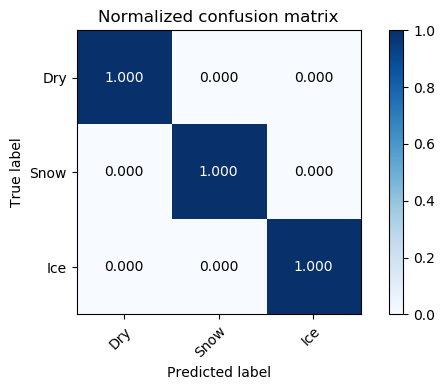

In [88]:
# Plot non-normalized confusion matrix
#plot_confusion_matrix(val_real, val_pred, classes=['Dry','Snow','Ice'],title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(val_real, val_pred, classes=['Dry','Snow','Ice'], normalize=True,
                      title='Normalized confusion matrix')
plt.show()

## Check wrong data

In [29]:
wrong_index = np.where(val_real != val_pred)[0]
len(wrong_index)

72

In [58]:
X_valid_wrong_dry = X_valid[wrong_index][y_valid[wrong_index] == 1]
X_valid_wrong_dry[1]

array([[ 1.9444,  1.4815, -0.7351, -0.7695],
       [ 1.9444,  1.4815, -0.6625, -0.6985],
       [ 1.9444,  1.4815, -0.5899, -0.6276],
       [ 1.9444,  1.4815, -0.5168, -0.5572],
       [ 1.9444,  1.4815, -0.4442, -0.4862],
       [ 1.9444,  1.4815, -0.371 , -0.4152],
       [ 1.9444,  1.4815, -0.2984, -0.3442],
       [ 1.9444,  1.4815, -0.2258, -0.2733],
       [ 1.9444,  1.4815, -0.1527, -0.2023],
       [ 1.9444,  1.4815, -0.0801, -0.1313]], dtype=float32)

In [30]:
def draw_wrong_segments(samples, targets, targets_pred, wrong_index, locations, pave_type, nrow = 2, ncol = 3):
    #samples = ['ACCELERATION', 'WACCELERATION', 'SPEED', 'WHEELSPEED']
    #locations = [Lons, Lats, veh_no, inter_no, max_acc, Time]
    
    wrong_indexs = [index for index in wrong_index if targets[index] == pave_type]
    indexs_list = random.sample(wrong_indexs, k=min(nrow*ncol, len(wrong_indexs)))
    fig = plt.figure(figsize=(20, 12))
    fig.subplots_adjust(wspace=0.3, hspace=.2)
    
    for i, index in enumerate(indexs_list):
        Veh = samples[index]
        Vehs_NO = int(locations[index, 2])
        Inter_NO = int(locations[index, 3])
        End_time = locations[index, 5]
        
        #Time_small = [End_time - i*0.1 for i in range(10)[::-1]] 
        Time_small = [1,2,3,4,5,6,7,8,9,10] 
        Accel_small = Veh[:,0]
        WAccel_small = Veh[:,1]
        Speed_small = Veh[:,2]
        Wspeed_small = Veh[:,3]
        
        ax1 = plt.subplot(nrow, ncol, i + 1)
        ax1.plot(Time_small, Speed_small, 'r', label='Driving speed')
        ax1.plot(Time_small, Wspeed_small, 'b', label='Wheel speed')
        ax1.plot(np.nan, 'k', label = 'WAcceleration')
        ax1.plot(np.nan, 'g', label='Acceleration')

        ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax1.yaxis.set_major_locator(ticker.MultipleLocator(5))
        ax1.set_ylim(0, 70)

        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('Speed (km/h)')

        ax2 = ax1.twinx()
        ax2.plot(Time_small, WAccel_small, 'y', label='Acceleration')
        ax2.plot(Time_small, Accel_small, 'g', label='Acceleration')
        ax2.set_ylabel('Acceleration (m/s2)')
        ax2.set_ylim(-8, 4)
        ax2.yaxis.set_major_locator(ticker.MultipleLocator(1))

        ax1.legend(loc="lower right", frameon=False)
        ax1.set_title(
            f"Veh: {Vehs_NO}  Real: {pave_type}  Pred: {targets_pred[index]}  Inter: {Inter_NO}  Max_acc: {locations[index,4]}  Time: {locations[index,5]}")
        ax1.grid()

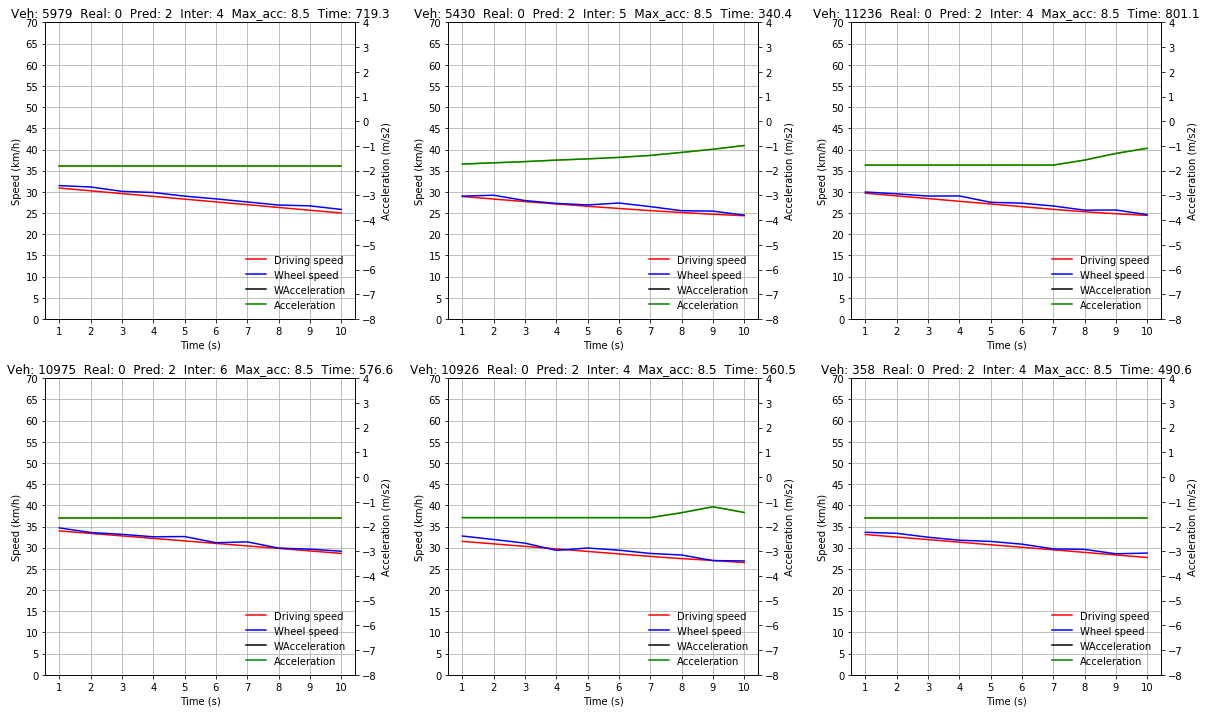

In [33]:
draw_wrong_segments(train_X[valid_indices], val_real ,val_pred, wrong_index, valid_loc, 0, 2,3)

In [34]:
draw_wrong_segments(train_X[valid_indices], val_real ,val_pred, wrong_index, valid_loc, 1, 2,3)

<Figure size 1440x864 with 0 Axes>

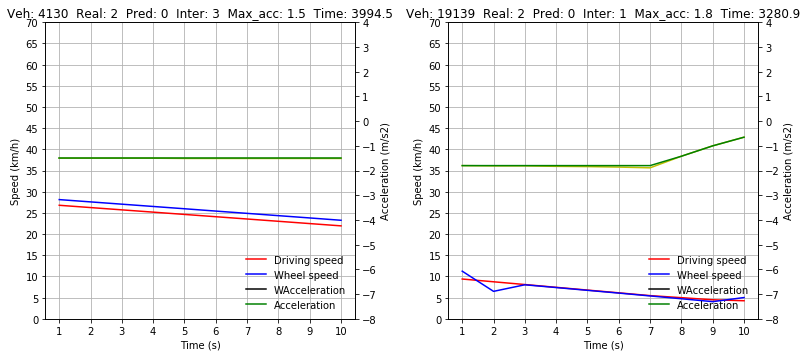

In [35]:
draw_wrong_segments(train_X[valid_indices], val_real ,val_pred, wrong_index, valid_loc, 2, 2,3)

## Test

In [1]:
samples = np.load('samples.npy')
targets = np.load('targets.npy')
locations = np.load('locations.npy')
samples.shape, targets.shape, locations.shape

((732910, 10, 4), (732910,), (732910, 6))

In [4]:
scaler = joblib.load("scaler")
samples_scaled = scaler.transform(samples.reshape(-1,4)).reshape(-1,10,4).astype('float32')
targets = targets.astype('int64')

### Fastai

In [45]:
class Time_Series_Data(Dataset):
    def __init__(self, train_x, train_y):
        self.X = train_x
        self.y = train_y
    def __getitem__(self, item):
        x_t = self.X[item]
        y_t = self.y[item]
        return x_t, y_t
    def __len__(self):
        return len(self.X)
    
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, output_size=3):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [46]:
input_size = 4
hidden_size = 32
num_layers = 4
dropout = 0.5
net = LSTM(input_size, hidden_size, num_layers, dropout)

In [47]:
test_ds = Time_Series_Data(samples_scaled, targets)
databunch = DataBunch.create(test_ds, test_ds, device="cuda:0", bs=512)
learn = Learner(databunch, net)
learn = learn.load('S1_LSTM')
test_pred, test_real = learn.get_preds(databunch.test_dl)
test_pred = np.argmax(test_pred.numpy(), axis=1)

In [48]:
test_acc = accuracy_score(test_real, test_pred)
test_acc

0.999922227831521

### Pytorch

In [51]:
input_size = 4
hidden_size = 32
num_layers = 4
dropout = 0.5
model = LSTM(input_size, hidden_size, num_layers, dropout)
model.load_state_dict(torch.load('models/S1_LSTM.pth')['model'])
model = model.cuda()
model.eval()

LSTM(
  (lstm): LSTM(4, 32, num_layers=4, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=32, out_features=3, bias=True)
)

In [72]:
def predict(model, dataloader):
    num_elements = len(dataloader.dataset)
    num_batches = len(dataloader)
    batch_size = dataloader.batch_size
    predictions = torch.zeros(num_elements).cuda()
    for i, (data, _) in enumerate(dataloader):
        start = i*batch_size
        end = start + batch_size
        if i == num_batches - 1:
            end = num_elements
        pred = model(data.cuda())
        pred = torch.max(pred.data, 1)[1]
        predictions[start:end] = pred
    return predictions.cpu().numpy()

In [79]:
batch_size = 512
test_ds = Time_Series_Data(samples_scaled, targets)
test_loader = DataLoader(dataset = test_ds, batch_size=batch_size, num_workers=12)
test_pred = predict(model, test_loader)

In [74]:
test_acc = accuracy_score(test_real, test_pred)
test_acc

0.999922227831521

## Real-time evaluation

In [143]:
def plot_detected_road_location(test_pred, locations, start_t, end_t):
    #locations = [Lons, Lats, veh_no, inter_no, max_acc, Time]
    #pave_type = 0,1,2
    fig = plt.figure(figsize=(15, 8))
    fig.subplots_adjust(wspace=0.3, hspace=0.3)
    loc = locations[(locations[:,5] <= 500)]
    loc_dry = locations[(test_pred == 0) & (locations[:, 5] >= start_t) & (locations[:, 5] <= end_t)]
    loc_snow = locations[(test_pred == 1) & (locations[:, 5] >= start_t) & (locations[:, 5] <= end_t)]
    loc_ice = locations[(test_pred == 2)& (locations[:, 5] >= start_t) & (locations[:, 5] <= end_t)]
     
    for i in range(1,7):
        plt.subplot(2,3,i)
        plt.scatter(loc[loc[:,3] == i, 0], loc[loc[:,3] == i, 1], c='y')
        plt.scatter(loc_dry[loc_dry[:,3]==i,0], loc_dry[loc_dry[:,3]==i,1], c='g', label='Dry')
        plt.scatter(loc_snow[loc_snow[:,3]==i,0], loc_snow[loc_snow[:,3]==i,1], c='b', label='Snow')
        plt.scatter(loc_ice[loc_ice[:,3]==i,0], loc_ice[loc_ice[:,3]==i,1], c='r', label='Ice')
        plt.legend()
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title(f'Detected Road Type at #{i} Inter ({start_t}~{end_t})')

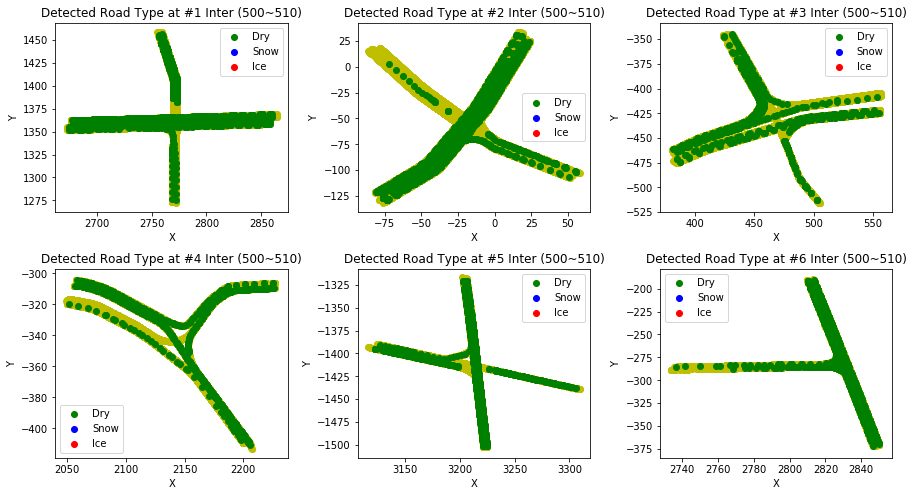

In [154]:
plot_detected_road_location(test_pred, locations, 500, 510)

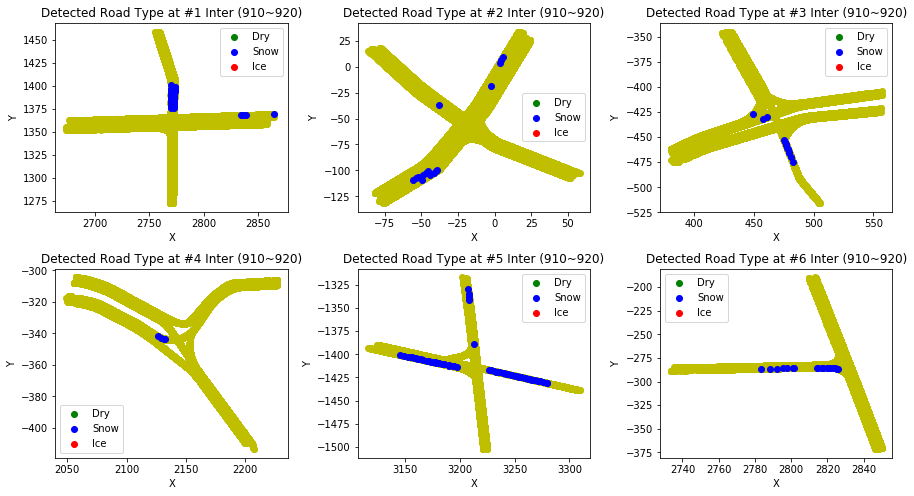

In [151]:
plot_detected_road_location(test_pred, locations, 910, 920)

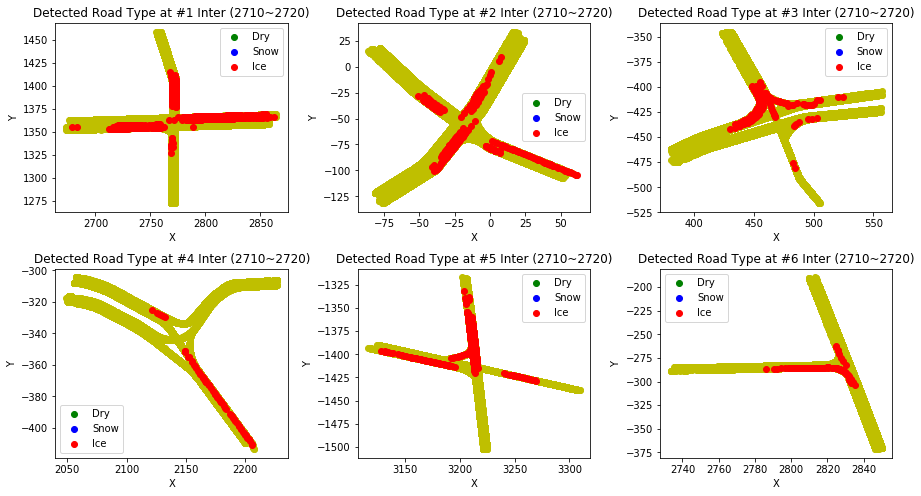

In [149]:
plot_detected_road_location(test_pred, locations, 2710, 2720)